# Frozen Lake Environment
Frozen lake involves crossing a frozen lake from start to goal without falling into any 
holes by walking over the frozen lake.

## Action Space
There are 4 discrete actions indicating which direction to move the player.
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

## Rewards
Reward schedule:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0


https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Observation Space Discrete(16)
Action Space Shape 4


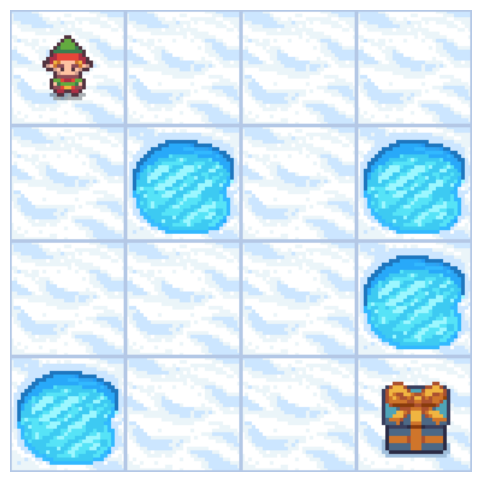

In [1]:
import json
from datetime import datetime
from functools import partial
from pathlib import Path
from typing import NamedTuple

import gymnasium as gym
import numpy as np
import torch
from dotenv import dotenv_values
from huggingface_hub import HfApi, snapshot_download
from huggingface_hub.repocard import metadata_eval_result, metadata_save
from matplotlib import pyplot as plt
from tqdm import tqdm

from r2seedo.io import load_keypair, load_n_verify_model, sign_n_save_model
from r2seedo.models.q_table import QTable, train_for_one_episode
from r2seedo.utils.environment import capture_replay

env = gym.make(
    id="FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="rgb_array"
)


print("Observation Space", env.observation_space)
print("Action Space Shape", env.action_space.n)

_ = env.reset()
frame = env.render()

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(frame)
ax.axis("off");

# Create and Initialize the Q-table 

In [2]:
agent = QTable(
    num_states=env.observation_space.n,
    num_actions=env.action_space.n,
    discount_factor=0.95,
    state_names=[f"{i*4+j}:({i},{j})" for i in range(4) for j in range(4)],
    action_names=["L", "D", "R", "U"],
)

print(agent)
print(agent.to_dataframe())

QTable(num_states=16, num_actions=4, discount_factor=0.95)
            L    D    R    U
0:(0,0)   0.0  0.0  0.0  0.0
1:(0,1)   0.0  0.0  0.0  0.0
2:(0,2)   0.0  0.0  0.0  0.0
3:(0,3)   0.0  0.0  0.0  0.0
4:(1,0)   0.0  0.0  0.0  0.0
5:(1,1)   0.0  0.0  0.0  0.0
6:(1,2)   0.0  0.0  0.0  0.0
7:(1,3)   0.0  0.0  0.0  0.0
8:(2,0)   0.0  0.0  0.0  0.0
9:(2,1)   0.0  0.0  0.0  0.0
10:(2,2)  0.0  0.0  0.0  0.0
11:(2,3)  0.0  0.0  0.0  0.0
12:(3,0)  0.0  0.0  0.0  0.0
13:(3,1)  0.0  0.0  0.0  0.0
14:(3,2)  0.0  0.0  0.0  0.0
15:(3,3)  0.0  0.0  0.0  0.0


# Train Q-Learning Agent

## Define training loop

In [3]:
def train(
    agent: QTable,
    env: gym.Env,
    num_episodes: int,
    max_steps: int,
    learning_rate: float,
    max_epsilon: float,
    min_epsilon: float,
    decay_rate: float,
) -> list[float]:
    """Train a Q-table agent in an environment for a specified number of episodes."""
    # Define exploration rate schedule
    epsilon_schedule = min_epsilon + (max_epsilon - min_epsilon) * np.exp(
        -decay_rate * np.arange(num_episodes)
    )

    episode_rewards = [
        train_for_one_episode(agent, env, max_steps, learning_rate, epsilon)
        for epsilon in tqdm(epsilon_schedule)
    ]

    return episode_rewards

In [4]:
# Test training for one episode
train_for_one_episode(
    agent, env, max_steps=100, learning_rate=0.1, epsilon=1, verbose=True
)

0: state= 0, action= 3, reward=   0, total_reward=    0
1: state= 0, action= 3, reward=   0, total_reward=    0
2: state= 1, action= 2, reward=   0, total_reward=    0
3: state= 0, action= 0, reward=   0, total_reward=    0
4: state= 0, action= 3, reward=   0, total_reward=    0
5: state= 0, action= 3, reward=   0, total_reward=    0
6: state= 4, action= 1, reward=   0, total_reward=    0
7: state= 4, action= 0, reward=   0, total_reward=    0
8: state= 8, action= 1, reward=   0, total_reward=    0
9: state= 4, action= 3, reward=   0, total_reward=    0
10: state= 0, action= 3, reward=   0, total_reward=    0
11: state= 0, action= 3, reward=   0, total_reward=    0
12: state= 1, action= 2, reward=   0, total_reward=    0
13: state= 1, action= 3, reward=   0, total_reward=    0
14: state= 2, action= 2, reward=   0, total_reward=    0
15: state= 6, action= 1, reward=   0, total_reward=    0
16: state= 5, action= 0, reward=   0, total_reward=    0


0.0

## Run training loop

100%|██████████| 10000/10000 [00:02<00:00, 4816.52it/s]


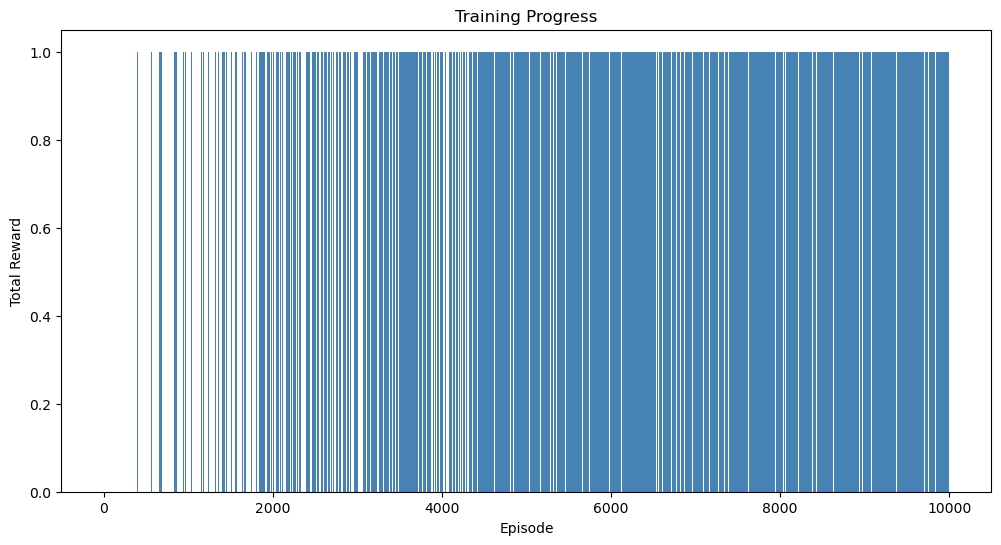

In [5]:
training_progress = train(
    agent,
    env,
    num_episodes=10_000,
    max_steps=100,
    learning_rate=0.7,
    max_epsilon=1,
    min_epsilon=0.05,
    decay_rate=0.0005,
)

_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    x=np.arange(len(training_progress)),
    height=training_progress,
    width=1.0,
    color="steelblue",
)
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Training Progress");

In [6]:
print("Trained Q-Table:")
agent.to_dataframe()

Trained Q-Table:


,L,D,R,U
"0:(0,0)",0.735092,0.773781,0.773781,0.735092
"1:(0,1)",0.735092,0.000000,0.814506,0.773781
"2:(0,2)",0.773781,0.857375,0.773781,0.814506
"3:(0,3)",0.814506,0.000000,0.773781,0.773781
"4:(1,0)",0.773781,0.814506,0.000000,0.735092
"5:(1,1)",0.000000,0.000000,0.000000,0.000000
"6:(1,2)",0.000000,0.902500,0.000000,0.814506
"7:(1,3)",0.000000,0.000000,0.000000,0.000000
"8:(2,0)",0.814506,0.000000,0.857375,0.773781
"9:(2,1)",0.814506,0.902500,0.902500,0.000000


# Evaluate agent

In [7]:
class EvalResult(NamedTuple):
    """Summary of total rewards over evaluation episodes."""

    env_id: str
    map_name: str
    is_slippery: bool
    num_episodes: int
    mean_reward: float
    std_reward: float
    eval_datetime: str = datetime.now().isoformat()


def evaluate(
    agent: QTable, env: gym.Env, num_episodes: int, max_steps: int
) -> EvalResult:
    """Evaluate the agent in the environment for a number of episodes."""
    total_rewards = []
    for _ in tqdm(range(num_episodes)):
        state, _ = env.reset()
        state = torch.tensor(state)
        total_reward = 0
        for _ in range(max_steps):
            action = agent.get_action(state, epsilon=0)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            next_state = torch.tensor(next_state)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        total_rewards.append(total_reward)

    return EvalResult(
        env_id=env.spec.id,
        map_name=env.spec.kwargs.get("map_name"),
        is_slippery=env.spec.kwargs.get("is_slippery"),
        num_episodes=num_episodes,
        mean_reward=np.mean(total_rewards),
        std_reward=np.std(total_rewards),
    )

In [8]:
evaluate(agent, env, num_episodes=100, max_steps=100)._asdict()

100%|██████████| 100/100 [00:00<00:00, 6534.51it/s]


{'env_id': 'FrozenLake-v1',
 'map_name': '4x4',
 'is_slippery': False,
 'num_episodes': 100,
 'mean_reward': 1.0,
 'std_reward': 0.0,
 'eval_datetime': '2024-04-19T10:07:46.944055'}

# Slippery Environment

Observation Space Discrete(16)
Action Space Shape 4


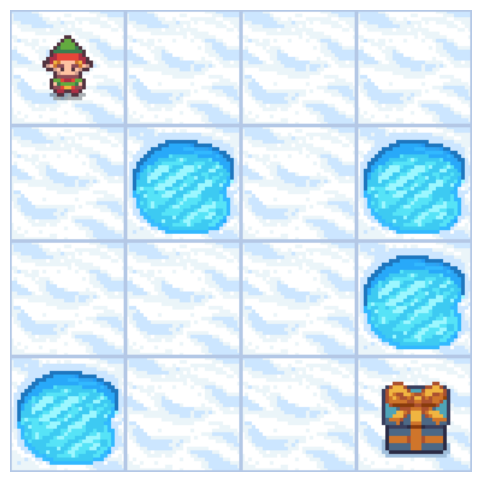

In [9]:
env_slippery = gym.make(
    id="FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="rgb_array"
)


print("Observation Space", env.observation_space)
print("Action Space Shape", env.action_space.n)

_ = env_slippery.reset()
frame = env_slippery.render()

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(frame)
ax.axis("off");

In [10]:
agent_slippery = QTable(
    num_states=env_slippery.observation_space.n,
    num_actions=env_slippery.action_space.n,
    discount_factor=0.95,
    state_names=[f"{i*4+j}:({i},{j})" for i in range(4) for j in range(4)],
    action_names=["L", "D", "R", "U"],
)
agent_slippery

QTable(num_states=16, num_actions=4, discount_factor=0.95)

100%|██████████| 30000/30000 [00:18<00:00, 1589.08it/s]


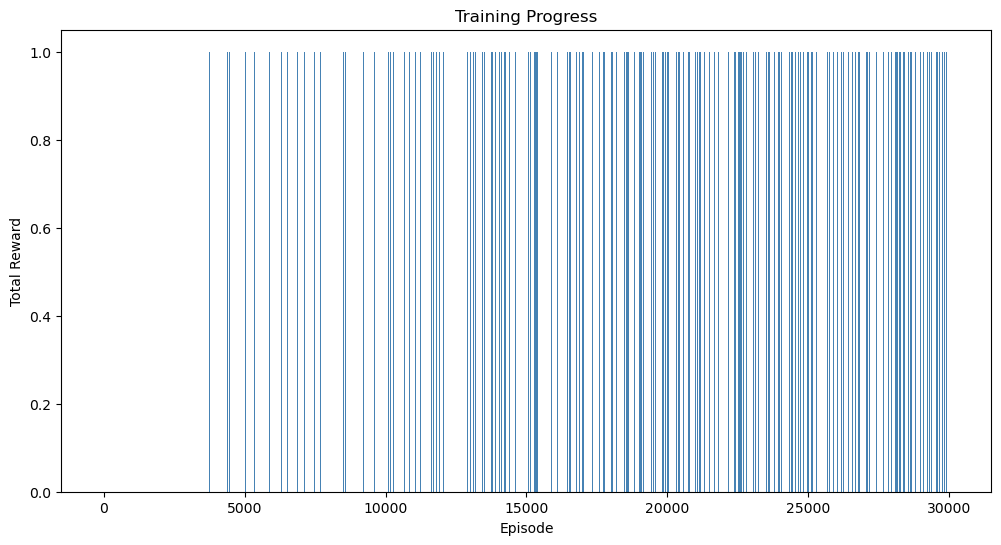

In [11]:
training_progress = train(
    agent_slippery,
    env_slippery,
    num_episodes=30_000,
    max_steps=100,
    learning_rate=0.7,
    max_epsilon=1,
    min_epsilon=0.05,
    decay_rate=0.00025,
)

_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    x=np.arange(len(training_progress)),
    height=training_progress,
    width=1.0,
    color="steelblue",
)
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Training Progress");

In [12]:
eval_results_slippery = evaluate(
    agent_slippery, env_slippery, num_episodes=100, max_steps=100
)
eval_results_slippery._asdict()

100%|██████████| 100/100 [00:00<00:00, 2491.83it/s]


{'env_id': 'FrozenLake-v1',
 'map_name': '4x4',
 'is_slippery': True,
 'num_episodes': 100,
 'mean_reward': 0.38,
 'std_reward': 0.48538644398046393,
 'eval_datetime': '2024-04-19T10:07:46.944055'}

# Save model to hub

In [ ]:
# Config
env_config = dotenv_values()
api = HfApi(token=env_config["HF_TOKEN"])
model_name = "q-table-frozen-lake"
repo_id = f"libertininick/{model_name}"

In [ ]:
# Create the repo
repo_url = api.create_repo(repo_id=repo_id, exist_ok=True)

# Download files
repo_local_path = Path(snapshot_download(repo_id, local_dir=f"../models/{model_name}"))

In [ ]:
# Sign and save the model to local directory
sign_n_save_model(
    model=agent_slippery,
    destination=repo_local_path,
    keypair=load_keypair("../models/private.pem", env_config["MODEL_KEY_PASSWORD"]),
    overwrite=True,
)

# Don't forget to run `dvc add` on the model file
# $ dvc add ../models/q-table-frozen-lake/model.joblib

In [ ]:
# Save evaluation metrics
with open(repo_local_path / "eval_results.json", "w") as f:
    json.dump(eval_results_slippery._asdict(), f, indent=2)

In [ ]:
# Build and save model card
model_card = f"""
# **Q-Learning** Agent playing **{eval_results_slippery.env_id}**

This is a trained **Q-Learning** agent playing **{eval_results_slippery.env_id}**.

## Usage

```python
import gymnasium as gym
from huggingface_hub import snapshot_download

# https://github.com/libertininick/r2seedo
from r2seedo.io import load_n_verify_model

# Download model snapshot from Hugging Face Hub
repo_local_path = snapshot_download(
  repo_id="{repo_id}",
  local_dir="path/to/download",
)

# Load the model from the snapshot
model = load_n_verify_model(repo_local_path)

# Create the environment
env = env_slippery = gym.make(
  id="{eval_results_slippery.env_id}",
  map_name="{eval_results_slippery.map_name}",
  is_slippery={eval_results_slippery.is_slippery},
)
```
"""

env_name = f"{eval_results_slippery.env_id}-{eval_results_slippery.map_name}-slippery"
metadata = {
    "tags": [env_name, "q-learning", "reinforcement-learning", "custom-implementation"],
    **metadata_eval_result(
        model_pretty_name=model_name,
        task_pretty_name="reinforcement-learning",
        task_id="reinforcement-learning",
        metrics_pretty_name="mean_reward",
        metrics_id="mean_reward",
        metrics_value=(
            f"{eval_results_slippery.mean_reward:.2f} "
            f"+/- {eval_results_slippery.std_reward:.2f}"
        ),
        dataset_pretty_name=env_name,
        dataset_id=env_name,
    ),
}

readme_path = repo_local_path / "README.md"

with readme_path.open("w", encoding="utf-8") as f:
    f.write(model_card)

metadata_save(readme_path, metadata)

In [ ]:
# Push to hub
api.upload_folder(
    repo_id=repo_id,
    folder_path=repo_local_path,
    path_in_repo=".",
    ignore_patterns="*.dvc",
)

# Capture replay

In [5]:
agent: QTable = load_n_verify_model("../models/q-table-frozen-lake")
env_slippery = gym.make(
    id="FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="rgb_array"
)

rewards = capture_replay(
    env_slippery,
    partial(agent.get_action, epsilon=0),
    video_folder="../models/q-table-frozen-lake",
    max_steps=100,
)

sum(rewards)